In [1]:
# 1. Import Necessary Libraries

import warnings
warnings.filterwarnings("ignore")

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Time Series Forecasting
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# System and Environment
import os
import sys

# Set Display Options
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [2]:
# 2. Load the Dataset
csv_path = 'owid-energy-data.csv'  # Adjust path as necessary
df_energy = pd.read_csv(csv_path)
df_energy.head()  # Display first few rows


,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.87,1.550,NaN,569.557,NaN,NaN,NaN,NaN,NaN,76.03,NaN,NaN,NaN,NaN,20.081,NaN,378.61,378.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.36,NaN,NaN,80.653,NaN,NaN,NaN,NaN,NaN,164.26,NaN,NaN,NaN,NaN,NaN,43.385,NaN,215.64,NaN,NaN,NaN,NaN,50.45,NaN,13.325,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,65.07,NaN,NaN,NaN,NaN,NaN,17.187,NaN,NaN,22.80,16.93,NaN,NaN,NaN,NaN,NaN,6.022,4.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.46,1.596,NaN,567.642,NaN,NaN,NaN,NaN,NaN,86.26,NaN,NaN,NaN,NaN,21.307,NaN,404.85,404.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.66,NaN,NaN,80.934,NaN,NaN,NaN,NaN,NaN,190.41,NaN,NaN,NaN,NaN,NaN,47.032,NaN,229.81,NaN,NaN,NaN,NaN,54.33,NaN,13.420,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,50.99,NaN,NaN,NaN,NaN,NaN,12.595,NaN,NaN,22.86,16.40,NaN,NaN,NaN,NaN,NaN,5.647,4.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,Na

In [3]:
df_energy.columns

Index(['country', 'year', 'iso_code', 'population', 'gdp', 'biofuel_cons_change_pct', 'biofuel_cons_change_twh', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita',
       ...
       'solar_share_elec', 'solar_share_energy', 'wind_cons_change_pct', 'wind_cons_change_twh', 'wind_consumption', 'wind_elec_per_capita', 'wind_electricity', 'wind_energy_per_capita', 'wind_share_elec', 'wind_share_energy'], dtype='object', length=129)

In [4]:
df_energy.isna().sum()

country                       0
year                          0
iso_code                   5000
population                 3365
gdp                       10037
                          ...  
wind_elec_per_capita      14534
wind_electricity          13578
wind_energy_per_capita    17659
wind_share_elec           14615
wind_share_energy         17619
Length: 129, dtype: int64

There is a lot of missing data/NaN values so we need to process the data and deal with those values.

In [5]:
# 3. Feature Engineering and Preprocessing

# Derived Features for Emissions Per Capita and Energy Intensity
df_energy['emissions_per_capita'] = df_energy['greenhouse_gas_emissions'] / df_energy['population']
df_energy['energy_intensity'] = df_energy['primary_energy_consumption'] / df_energy['gdp']

# Fill Missing Values for Derived Features
numeric_columns = df_energy.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values in numeric columns with median
df_energy[numeric_columns] = df_energy[numeric_columns].fillna(df_energy[numeric_columns].median())

# Calculate GDP and Population Change Percentages for Trends
df_energy['gdp_change_pct'] = df_energy['gdp'].pct_change()
df_energy['population_change_pct'] = df_energy['population'].pct_change()

# Fill Missing Values for Percent Changes
df_energy[['gdp_change_pct', 'population_change_pct']] = df_energy[['gdp_change_pct', 'population_change_pct']].fillna(0)

# Select Features and Targets
features_energy_share = [
    'year', 'population', 'gdp', 'gdp_change_pct', 'population_change_pct',
    'biofuel_share_energy', 'coal_share_energy', 'fossil_share_energy', 'renewables_share_energy'
]

# Targets: Energy Shares, Emissions Per Capita, Energy Intensity
targets_extended = ['coal_share_energy', 'gas_share_energy', 'renewables_share_energy', 'emissions_per_capita', 'energy_intensity']

# Split Features and Targets
X = df_energy[features_energy_share]
y_coal = df_energy['coal_share_energy']
y_gas = df_energy['gas_share_energy']
y_renewables = df_energy['renewables_share_energy']
y_emissions_per_capita = df_energy['emissions_per_capita']
y_energy_intensity = df_energy['energy_intensity']


In [6]:
df_energy.isna().sum()

country                     0
year                        0
iso_code                 5000
population                  0
gdp                         0
                         ... 
wind_share_energy           0
emissions_per_capita        0
energy_intensity            0
gdp_change_pct              0
population_change_pct       0
Length: 133, dtype: int64

ISO code is only the country code which we do not care a lot about so we can ignore it. We are now free to move into regression model generation and splitting the database to create the model.

In [7]:
# 4. Train Models for Predictions

# Train-test Split
X_train, X_test, y_train_coal, y_test_coal = train_test_split(X, y_coal, test_size=0.2, random_state=42)
_, _, y_train_gas, y_test_gas = train_test_split(X, y_gas, test_size=0.2, random_state=42)
_, _, y_train_renewables, y_test_renewables = train_test_split(X, y_renewables, test_size=0.2, random_state=42)

# Additional Targets
_, _, y_train_emissions, y_test_emissions = train_test_split(X, y_emissions_per_capita, test_size=0.2, random_state=42)
_, _, y_train_intensity, y_test_intensity = train_test_split(X, y_energy_intensity, test_size=0.2, random_state=42)

# Train Models (Random Forest Regressor)
models_energy_share = {
    'Coal': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gas': RandomForestRegressor(n_estimators=100, random_state=42),
    'Renewables': RandomForestRegressor(n_estimators=100, random_state=42)
}

models_extended = {
    'Emissions Per Capita': RandomForestRegressor(n_estimators=100, random_state=42),
    'Energy Intensity': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Fit Models for Energy Shares
models_energy_share['Coal'].fit(X_train, y_train_coal)
models_energy_share['Gas'].fit(X_train, y_train_gas)
models_energy_share['Renewables'].fit(X_train, y_train_renewables)

# Fit Models for Emissions and Energy Intensity
models_extended['Emissions Per Capita'].fit(X_train, y_train_emissions)
models_extended['Energy Intensity'].fit(X_train, y_train_intensity)


RandomForestRegressor(random_state=42)

In [8]:
# 5. Global Predictions for All Countries

# Generate Predictions for Each Country
all_predictions = []

for country in df_energy['country'].unique():
    df_country = df_energy[df_energy['country'] == country]
    if len(df_country['coal_share_energy'].dropna()) > 2:  # Ensure enough data points
        result = seasonal_decompose(df_country['coal_share_energy'], model='additive', period=1)
        df_energy.loc[df_energy['country'] == country, 'trend_coal'] = result.trend.fillna(method='bfill').fillna(method='ffill')
    future_data = pd.DataFrame({
        'year': [2050],
        'population': [1.5 * df_country['population'].iloc[-1]],  # Example: 50% growth
        'gdp': [2.0 * df_country['gdp'].iloc[-1]],  # Example: 100% growth
        'gdp_change_pct': [df_country['gdp_change_pct'].mean()],
        'population_change_pct': [df_country['population_change_pct'].mean()],
        'biofuel_share_energy': [df_country['biofuel_share_energy'].iloc[-1]],
        'coal_share_energy': [df_country['coal_share_energy'].iloc[-1]],
        'fossil_share_energy': [df_country['fossil_share_energy'].iloc[-1]],
        'renewables_share_energy': [df_country['renewables_share_energy'].iloc[-1]]
    })

    # Predictions for Energy Shares
    coal_2050 = models_energy_share['Coal'].predict(future_data)
    gas_2050 = models_energy_share['Gas'].predict(future_data)
    renewables_2050 = models_energy_share['Renewables'].predict(future_data)

    # Predictions for Emissions and Energy Intensity
    emissions_2050 = models_extended['Emissions Per Capita'].predict(future_data)
    energy_intensity_2050 = models_extended['Energy Intensity'].predict(future_data)

    all_predictions.append({
        'country': country,
        'coal_share_2050': coal_2050[0],
        'gas_share_2050': gas_2050[0],
        'renewables_share_2050': renewables_2050[0],
        'emissions_per_capita_2050': emissions_2050[0],
        'energy_intensity_2050': energy_intensity_2050[0]
    })
def evaluate_model(model, X_test, y_test, label):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    print(f"{label} Model Performance:")
    print(f"  Mean Squared Error: {mse:.2f}")
    print(f"  Root Mean Squared Error: {rmse:.2f}")
    print(f"  R² Score: {r2:.2f}\n")
    return mse, rmse, r2

# Evaluate all energy share models
for name, model in models_energy_share.items():
    y_test = y_test_coal if name == 'Coal' else y_test_gas if name == 'Gas' else y_test_renewables
    evaluate_model(model, X_test, y_test, name)

# Evaluate extended models
for name, model in models_extended.items():
    y_test = y_test_emissions if name == 'Emissions Per Capita' else y_test_intensity
    evaluate_model(model, X_test, y_test, name)


Coal Model Performance:
  Mean Squared Error: 0.00
  Root Mean Squared Error: 0.02
  R² Score: 1.00

Gas Model Performance:
  Mean Squared Error: 4.67
  Root Mean Squared Error: 2.16
  R² Score: 0.93

Renewables Model Performance:
  Mean Squared Error: 0.00
  Root Mean Squared Error: 0.02
  R² Score: 1.00

Emissions Per Capita Model Performance:
  Mean Squared Error: 0.00
  Root Mean Squared Error: 0.00
  R² Score: 0.83

Energy Intensity Model Performance:
  Mean Squared Error: 0.00
  Root Mean Squared Error: 0.00
  R² Score: -0.00



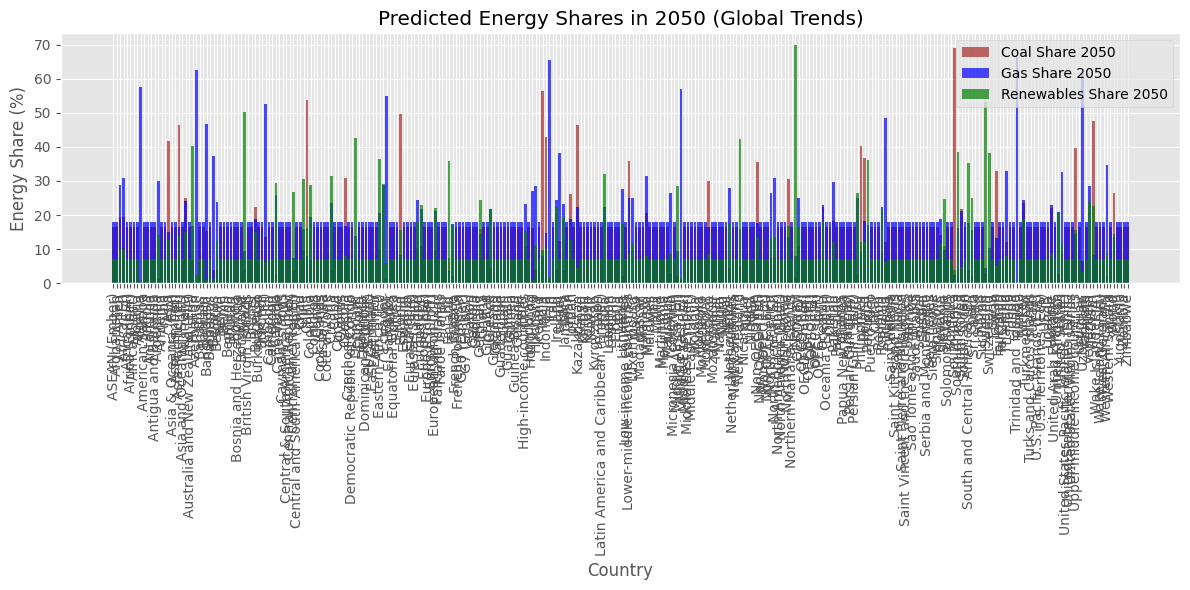

In [9]:
# Convert predictions to DataFrame for easier visualization
predictions_df = pd.DataFrame(all_predictions)

# Global Trends Plot (Energy Shares)
plt.figure(figsize=(12, 6))
plt.bar(predictions_df['country'], predictions_df['coal_share_2050'], label='Coal Share 2050', color='brown', alpha=0.7)
plt.bar(predictions_df['country'], predictions_df['gas_share_2050'], label='Gas Share 2050', color='blue', alpha=0.7)
plt.bar(predictions_df['country'], predictions_df['renewables_share_2050'], label='Renewables Share 2050', color='green', alpha=0.7)
plt.title("Predicted Energy Shares in 2050 (Global Trends)")
plt.ylabel("Energy Share (%)")
plt.xlabel("Country")
plt.xticks(rotation=90, fontsize=10)  # Rotate and adjust font size
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
import plotly.express as px

# Create a melted DataFrame for stacked bar plot
melted_df = predictions_df.melt(id_vars=['country'], 
                                 value_vars=['coal_share_2050', 'gas_share_2050', 'renewables_share_2050'], 
                                 var_name='Energy Type', value_name='Share')

# Plotly bar chart
fig = px.bar(melted_df, x='country', y='Share', color='Energy Type', 
             title='Predicted Energy Shares in 2050 (Global Trends)', 
             labels={'Share': 'Energy Share (%)'}, 
             hover_name='country')

# Update layout for better visualization
fig.update_layout(xaxis_tickangle=45, width=1200, height=700)
fig.show()

#### The above graph is interactive. You can scroll over each bar and it will tell you which country is representing
#### as well as the share of that particular energy


Displaying energy share predictions for india in 2050...
Predicted Energy Shares for india in 2050:
    country  coal_share_2050  gas_share_2050  renewables_share_2050  emissions_per_capita_2050  energy_intensity_2050
124   India         56.33478          8.0362                9.67493                   0.000002           1.471343e-09

Predicted Emissions Per Capita for india in 2050: 0.00 tons
Predicted Energy Intensity for india in 2050: 0.00 MWh per USD


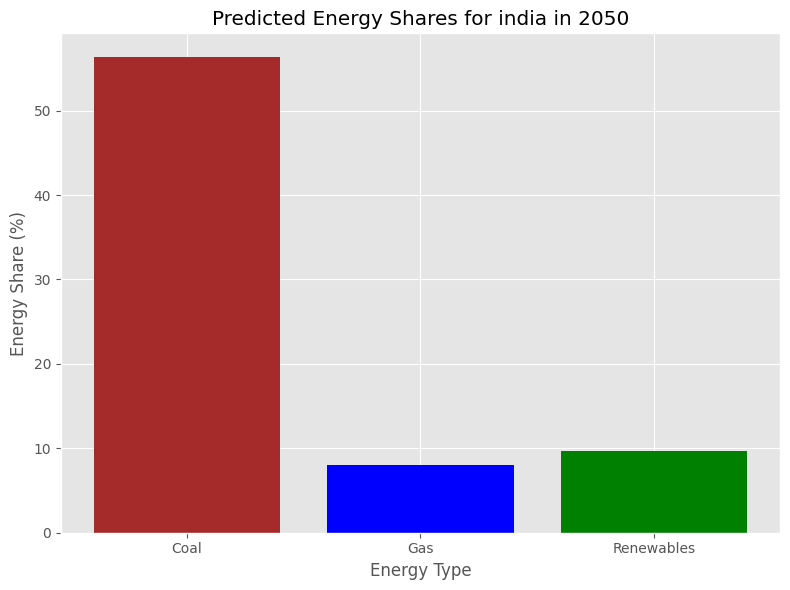

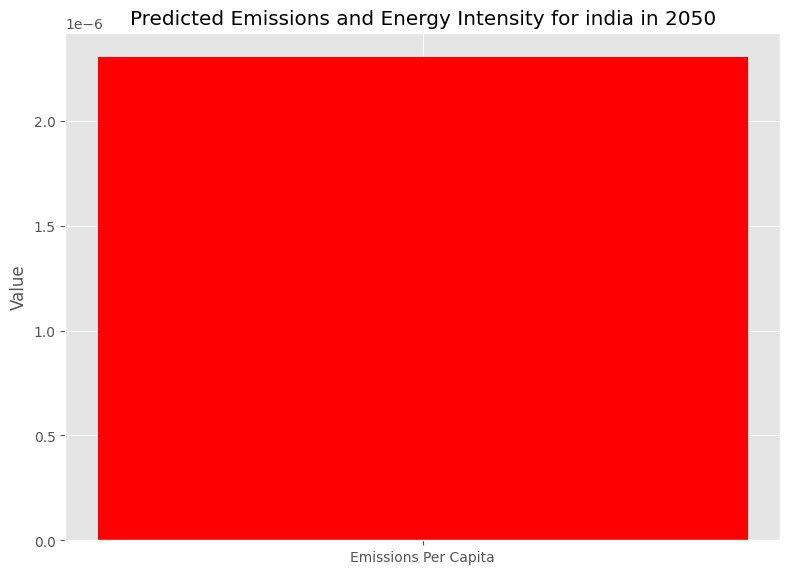

In [11]:
# 6. User Interaction - Focus on a Specific Country

country_name = input("Enter the country you want to focus on: ")

# Check if the country is in the dataset
if country_name.capitalize() not in df_energy['country'].unique():
    print(f"No data available for the country: {country_name}. Please choose another country.")
else:
    print(f"\nDisplaying energy share predictions for {country_name} in 2050...")

    # Filter the predictions for the selected country
    country_prediction = predictions_df[predictions_df['country'] == country_name.capitalize()]

    # Display the predictions for the selected country
    print(f"Predicted Energy Shares for {country_name} in 2050:")
    print(country_prediction)

    # Display emissions per capita and energy intensity for 2050
    print(f"\nPredicted Emissions Per Capita for {country_name} in 2050: {country_prediction['emissions_per_capita_2050'].values[0]:.2f} tons")
    print(f"Predicted Energy Intensity for {country_name} in 2050: {country_prediction['energy_intensity_2050'].values[0]:.2f} MWh per USD")

    # Plot for the specific country
    plt.figure(figsize=(8, 6))
    plt.bar(['Coal', 'Gas', 'Renewables'], country_prediction.iloc[0][['coal_share_2050', 'gas_share_2050', 'renewables_share_2050']], color=['brown', 'blue', 'green'])
    plt.title(f"Predicted Energy Shares for {country_name} in 2050")
    plt.ylabel("Energy Share (%)")
    plt.xlabel("Energy Type")
    plt.tight_layout()
    plt.show()

    # Plot emissions per capita and energy intensity for the specific country
    plt.figure(figsize=(8, 6))
    plt.bar(['Emissions Per Capita'], [country_prediction['emissions_per_capita_2050'].values[0]], color='red')
    plt.title(f"Predicted Emissions and Energy Intensity for {country_name} in 2050")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

In [12]:
import sqlite3 

# Connect to the database
conn = sqlite3.connect('energy_data.db') 
cursor = conn.cursor()

In [13]:
#Create the table
create_energy = '''
    CREATE TABLE IF NOT EXISTS energy_data (
        country TEXT,
        year INTEGER,
        population REAL,
        gdp REAL
        );'''

create_predictions = '''
    CREATE TABLE IF NOT EXISTS predictions (
        country TEXT,
        coal_share_2050 REAL,
        gas_share_2050 REAL,
        renewables_share_2050 REAL,
        emissions_per_capita_2050 REAL,
        energy_intensity_2050 REAL
    );'''

cursor.execute(create_energy)
cursor.execute(create_predictions)
conn.commit()

In [14]:
#load data in table
df_energy.to_sql('energy_data', conn, if_exists='replace', index=False)

21812

In [15]:
# Insert predictions into the predictions table
insert_query = '''
    INSERT INTO predictions (country, coal_share_2050, gas_share_2050, renewables_share_2050, emissions_per_capita_2050, energy_intensity_2050)
    VALUES (?, ?, ?, ?, ?, ?)
'''

rows_to_insert = predictions_df[['country', 'coal_share_2050', 'gas_share_2050', 'renewables_share_2050', 'emissions_per_capita_2050', 'energy_intensity_2050']].values.tolist()
cursor.executemany(insert_query, rows_to_insert)
conn.commit()

In [16]:
def run_query(query):
    cursor.execute(query)
    return cursor.fetchall()

#### Questions we can answer

In [17]:
#Get the top 5 countries with the highest GDP in a specific year
query = '''SELECT country, gdp FROM energy_data 
            WHERE year = 2020 
            ORDER BY gdp DESC LIMIT 5;'''
run_query(query)

[('World', 118590019731456.0),
 ('China', 24151844716544.0),
 ('United States', 18027359764480.0),
 ('India', 8945313775616.0),
 ('Japan', 4626661244928.0)]

In [18]:
#Calculate the average coal share for all countries in 2015
query = '''SELECT AVG(coal_share_energy) 
            FROM energy_data 
            WHERE year = 2015;'''
run_query(query)

[(17.07442361111111,)]

In [19]:
#Find the total renewable energy share for each country over all years
query = '''SELECT country, SUM(renewables_share_energy) 
            FROM energy_data 
            GROUP BY country;'''
run_query(query)

[('ASEAN (Ember)', 170.304),
 ('Afghanistan', 872.808),
 ('Africa', 903.921),
 ('Africa (EI)', 442.681),
 ('Africa (EIA)', 298.032),
 ('Africa (Ember)', 170.304),
 ('Africa (Shift)', 830.232),
 ('Albania', 872.808),
 ('Algeria', 515.177),
 ('American Samoa', 305.128),
 ('Angola', 879.904),
 ('Antarctica', 298.032),
 ('Antigua and Barbuda', 305.128),
 ('Argentina', 1008.047),
 ('Armenia', 219.976),
 ('Aruba', 262.552),
 ('Asia', 829.578),
 ('Asia & Oceania (EIA)', 298.032),
 ('Asia (Ember)', 170.304),
 ('Asia Pacific (EI)', 411.195),
 ('Asia and Oceania (Shift)', 830.232),
 ('Australia', 791.144),
 ('Australia and New Zealand (EIA)', 298.032),
 ('Austria', 2206.905),
 ('Azerbaijan', 161.455),
 ('Bahamas', 305.128),
 ('Bahrain', 879.904),
 ('Bangladesh', 636.759),
 ('Barbados', 872.808),
 ('Belarus', 45.139),
 ('Belgium', 583.28),
 ('Belize', 305.128),
 ('Benin', 305.128),
 ('Bermuda', 305.128),
 ('Bhutan', 305.128),
 ('Bolivia', 879.904),
 ('Bosnia and Herzegovina', 227.072),
 ('Botswan

In [20]:
#Determine the year with the highest average emissions per capita
query = '''SELECT year, AVG(emissions_per_capita) AS average_emissions 
            FROM energy_data 
            GROUP BY year 
            ORDER BY average_emissions DESC 
            LIMIT 1;'''
run_query(query)

[(2022, 1.685054608284065e-06)]

In [21]:
#List countries with a predicted coal share in 2050 greater than 25%
query = '''SELECT country
            FROM predictions 
            WHERE coal_share_2050 > 25;'''
run_query(query)

[('Asia',),
 ('Asia Pacific (EI)',),
 ('Australia',),
 ('China',),
 ('Czechia',),
 ('Estonia',),
 ('India',),
 ('Indonesia',),
 ('Japan',),
 ('Kazakhstan',),
 ('Lower-middle-income countries',),
 ('Morocco',),
 ('Non-OECD (EI)',),
 ('North Macedonia',),
 ('Philippines',),
 ('Poland',),
 ('South Africa',),
 ('Taiwan',),
 ('Upper-middle-income countries',),
 ('Vietnam',),
 ('World',)]

In [22]:
#Get the predicted energy shares for the countries with the highest population in 2023

query = '''SELECT p.country, p.coal_share_2050, p.gas_share_2050, p.renewables_share_2050
FROM predictions p
JOIN energy_data e ON p.country = e.country
WHERE e.year = 2023
ORDER BY e.population DESC
LIMIT 10;
'''
run_query(query)

[('World', 26.46623999999998, 13.53861, 14.568369999999986),
 ('Asia', 41.85617, 15.14375, 12.60571000000001),
 ('Lower-middle-income countries',
  35.72359999999999,
  25.030550000000016,
  8.501259999999991),
 ('Upper-middle-income countries',
  39.57391999999995,
  14.518139999999999,
  15.659580000000027),
 ('Africa', 19.560179999999974, 28.75968999999998, 9.827240000000012),
 ('India', 56.33477999999998, 8.036200000000001, 9.67493000000001),
 ('China', 53.737239999999936, 7.901399999999996, 16.161920000000013),
 ('High-income countries',
  10.684999999999995,
  23.276560000000003,
  15.384910000000014),
 ('Europe', 10.266470000000012, 24.485280000000003, 17.94679999999997),
 ('Low-income countries',
  16.562999999998446,
  17.915999999998448,
  7.0960000000002434)]

In [23]:
#Identify Countries with the Highest Emissions per Capita in 2050
query = '''SELECT country, emissions_per_capita_2050 
FROM predictions 
ORDER BY emissions_per_capita_2050 DESC 
LIMIT 5;
'''
run_query(query)

[('Reunion', 1.651413706023962e-05),
 ('Solomon Islands', 1.6419601360056654e-05),
 ('Malta', 1.6411064385588982e-05),
 ('Macao', 1.6341505922869043e-05),
 ('Iceland', 1.616713276079965e-05)]

In [24]:
#Find Countries Where Renewable Share > 50% in 2050
query = '''SELECT country, renewables_share_2050 
FROM predictions 
WHERE renewables_share_2050 > 50;
'''
run_query(query)

[('Brazil', 50.31707),
 ('Norway', 69.81020000000004),
 ('Sweden', 53.28661999999996)]